In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd

In [2]:
data = pd.read_csv("../data/IT_MA_TBAG50_original_data_v1.csv")

In [3]:
data.head(1)

,Company Name,Inc Year,Delete Flag,Acquisition Flag,2000-Return on equity,2001-Return on equity,2002-Return on equity,2003-Return on equity,2004-Return on equity,2005-Return on equity,...,2012-Log Total assets,2013-Log Total assets,2014-Log Total assets,2015-Log Total assets,2016-Log Total assets,2017-Log Total assets,2018-Log Total assets,2019-Log Total assets,2020-Log Total assets,2021-Log Total assets
0,3D P L M Global Services Pvt. Ltd.,2014.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.496508,5.494295,5.747799,6.224954,6.404402,7.014005,7.117124,7.117124


In [4]:
Y_column  = "Acquisition Flag"
#non_data_cols = ['Acquired','Year of acquisition']
non_data_cols = ['Acquisition Flag','Delete Flag', 'Inc Year','Company Name']

In [5]:
print(f"Total companies : {data.shape[0]}")
print(f"Companies that have all data for all years : {data.dropna().shape[0]}")

Total companies : 157
Companies that have all data for all years : 57


In [6]:
print(f"Total Acquired companies in the dataset : {data[data[Y_column]=='Yes'].shape[0]}")

Total Acquired companies in the dataset : 55


In [7]:
year_count = {}
year_cols = {}
cols = data.columns
for year in range(2000, 2022):
    year_count[f"{year}-"] = 0
    year_cols[f"{year}-"] = []
    for col in data.columns:
        if f"{year}-" in col:
            year_count[f"{year}-"] +=1
            year_cols[f"{year}-"].append(col)

print(year_count)

{'2000-': 17, '2001-': 17, '2002-': 17, '2003-': 17, '2004-': 17, '2005-': 17, '2006-': 17, '2007-': 17, '2008-': 17, '2009-': 17, '2010-': 17, '2011-': 17, '2012-': 17, '2013-': 17, '2014-': 17, '2015-': 17, '2016-': 17, '2017-': 17, '2018-': 17, '2019-': 17, '2020-': 17, '2021-': 17}


In [8]:
dims = year_cols["2015-"]
dims = [dim.replace("2015-","") for dim in dims]
dims

['Return on equity',
 'Return on sales',
 'Return on capital employed',
 'Net profit margin',
 'Return on total assets',
 'Free Cash Flow Return',
 'Quick ratio (times)',
 'Current ratio (times)',
 'Sales Growth Over Past Year',
 'Equity turnover',
 'Invested Capital Turnover',
 'Pre Tax Margin',
 'Debt to Asset ratio',
 'Debt to equity ratio (times)',
 'Interest Coverage Ratio',
 'Log Sales',
 'Log Total assets']

In [9]:
selected_dims=['Return on equity','Return on sales','Current ratio (times)'
                  ,'Sales Growth Over Past Year','Equity turnover','Net profit margin','Log Sales',
                  'Debt to equity ratio (times)','Interest Coverage Ratio','Free Cash Flow Return']

In [10]:
df_ma = data[data[Y_column]=='Yes']
df_ma.shape

(55, 378)

In [11]:
row_null = df_ma.isnull().sum(axis=1).tolist()
df_ma['null_count'] = row_null
print(df_ma[df_ma['null_count']==0].shape)
dfma = df_ma[df_ma['null_count']<400]
print(dfma.shape)

(24, 379)
(55, 379)


/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_2833/1318280318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma['null_count'] = row_null


In [12]:
# Not Acquired
df_non_ma = data[data[Y_column]=='No']
print(df_non_ma.shape)
row_null = df_non_ma.isnull().sum(axis=1).tolist()
df_non_ma['null_count'] = row_null
dfnonma = df_non_ma[df_non_ma['null_count']<300]
print(dfnonma.shape)

(102, 378)
(102, 379)


/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_2833/564073592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_ma['null_count'] = row_null


In [13]:
dfnonma.shape

(102, 379)

In [14]:
dfma.shape

(55, 379)

In [15]:
df = pd.concat([dfnonma, dfma])
df = df.sort_values(['Company Name']).reset_index(drop=True)
df.head(1)

,Company Name,Inc Year,Delete Flag,Acquisition Flag,2000-Return on equity,2001-Return on equity,2002-Return on equity,2003-Return on equity,2004-Return on equity,2005-Return on equity,...,2013-Log Total assets,2014-Log Total assets,2015-Log Total assets,2016-Log Total assets,2017-Log Total assets,2018-Log Total assets,2019-Log Total assets,2020-Log Total assets,2021-Log Total assets,null_count
0,3D P L M Global Services Pvt. Ltd.,2014.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.496508,5.494295,5.747799,6.224954,6.404402,7.014005,7.117124,7.117124,250


In [16]:
def count_above_mean(x):
    """
    Returns the number of values in x that are higher than the mean of x

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = np.mean(x)
    return np.where(x > m)[0].size

def count_below_mean(x):
    """
    Returns the number of values in x that are lower than the mean of x

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = np.mean(x)
    return np.where(x < m)[0].size

def last_location_of_maximum(x):
    """
    Returns the relative last location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    x = np.asarray(x)
    return 1.0 - np.argmax(x[::-1]) / len(x) if len(x) > 0 else np.NaN

def first_location_of_maximum(x):
    """
    Returns the first location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.argmax(x) / len(x) if len(x) > 0 else np.NaN

In [17]:
# Feature Extraction
features_df = pd.DataFrame()
for dim in selected_dims:
    cols = [f"{str(year)}-{dim}" for year in range(2000, 2022)]
    df_dim = df[cols]
    df_dim = df_dim.astype(float)
    features_df[f"{dim}__max"] = df_dim.max(axis=1)
    features_df[f"{dim}__min"] = df_dim.min(axis=1)
    features_df[f"{dim}__variance"] = df_dim.var(axis=1)
    features_df[f"{dim}__std"] = df_dim.std(axis=1)
    features_df[f"{dim}__sum"] = df_dim.sum(axis=1)
    features_df[f"{dim}__mean"] = df_dim.mean(axis=1)
    features_df[f"{dim}__skew"] = df_dim.skew(axis=1)
    features_df[f"{dim}__kurtosis"] = df_dim.kurtosis(axis=1)
    features_df[f"{dim}__cnt_above_mean"] = df_dim.apply(count_above_mean, axis=1)
    features_df[f"{dim}__cnt_below_mean"] = df_dim.apply(count_below_mean, axis=1)
    #features_df[f"{dim}__first_max"] = df_dim.apply(first_location_of_maximum, axis=1)
    #features_df[f"{dim}__last_max"] = df_dim.apply(last_location_of_maximum, axis=1)

features_df[Y_column] = pd.Categorical(df[Y_column]).codes

/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_2833/500522213.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[Y_column] = pd.Categorical(df[Y_column]).codes


In [18]:
features_df = features_df.apply(lambda x: x.fillna(x.mean()), axis=0)
features_df = features_df.dropna()
print(features_df.shape)
features_df.head()

(157, 101)


,Return on equity__max,Return on equity__min,Return on equity__variance,Return on equity__std,Return on equity__sum,Return on equity__mean,Return on equity__skew,Return on equity__kurtosis,Return on equity__cnt_above_mean,Return on equity__cnt_below_mean,...,Free Cash Flow Return__min,Free Cash Flow Return__variance,Free Cash Flow Return__std,Free Cash Flow Return__sum,Free Cash Flow Return__mean,Free Cash Flow Return__skew,Free Cash Flow Return__kurtosis,Free Cash Flow Return__cnt_above_mean,Free Cash Flow Return__cnt_below_mean,Acquisition Flag
0,92.94,19.84,843.110214,29.036360,355.890,50.841429,0.448024,-1.385823,3,4,...,-0.12,0.021079,0.145185,1.74,0.217500,-2.176409,5.422977,6,2,0
1,80.00,-6.17,484.391121,22.008887,177.820,12.701429,2.572869,7.167997,3,11,...,-0.57,0.037422,0.193448,-0.38,-0.027143,-1.600567,4.912798,11,3,0
2,149.21,-2772.61,438650.809600,662.307187,-3912.195,-186.295000,-3.534348,12.796227,19,2,...,-0.02,0.002916,0.054002,1.09,0.051905,0.591858,-0.829627,8,13,1
3,115.26,-25.16,778.296200,27.897960,348.260,15.830000,2.313777,7.469315,8,14,...,-0.18,0.008037,0.089651,-0.02,-0.000909,0.386624,1.760505,10,12,0
4,48.99,1.10,163.924383,12.803296,383.840,17.447273,0.817094,0.155304,10,12,...,-0.13,0.016498,0.128445,1.35,0.061364,0.793360,1.448517,11,11,0


In [19]:
X = features_df.drop(columns=[Y_column])
X_train, X_test, y_train, y_test = train_test_split(X, features_df[Y_column], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(117, 100) (40, 100) (117,) (40,)


In [20]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.825

In [21]:
feature_importances = {}
for feature, value in zip(features_df.columns, rf.feature_importances_):
    feature = feature.split("__")[0]
    if feature in feature_importances:
        val_list = feature_importances[feature]
    else:
        val_list = []
    val_list.append(np.round(value,4))
    feature_importances[feature] = val_list

In [22]:
feature_imp = {}
for key in feature_importances.keys():
    feature_imp[key] = np.sum(feature_importances[key])
    
sorted(feature_imp.items(), key=lambda x:x[1], reverse=True)

[('Current ratio (times)', 0.2425),
 ('Log Sales', 0.1704),
 ('Debt to equity ratio (times)', 0.09720000000000001),
 ('Sales Growth Over Past Year', 0.0807),
 ('Equity turnover', 0.0761),
 ('Free Cash Flow Return', 0.07319999999999999),
 ('Return on sales', 0.0731),
 ('Net profit margin', 0.0667),
 ('Interest Coverage Ratio', 0.06459999999999999),
 ('Return on equity', 0.055400000000000005)]

In [23]:
test_probs = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)
for prob, pred, actual in zip(test_probs, y_pred, y_test):
    print(prob, pred, actual)

[0.93 0.07] 0 0
[0.78 0.22] 0 0
[0.66 0.34] 0 1
[0.68 0.32] 0 0
[0.46 0.54] 1 0
[0.22 0.78] 1 1
[0.88 0.12] 0 0
[0.67 0.33] 0 0
[0.77 0.23] 0 1
[0.8 0.2] 0 0
[0.88 0.12] 0 0
[0.58 0.42] 0 1
[0.79 0.21] 0 1
[0.82 0.18] 0 0
[0.31 0.69] 1 1
[0.38 0.62] 1 1
[0.84 0.16] 0 0
[0.38 0.62] 1 1
[0.12 0.88] 1 1
[0.71 0.29] 0 0
[0.53 0.47] 0 1
[0.92 0.08] 0 0
[0.82 0.18] 0 0
[0.78 0.22] 0 0
[0.24 0.76] 1 1
[0.8 0.2] 0 0
[0.91 0.09] 0 0
[0.67 0.33] 0 0
[0.73 0.27] 0 0
[0.22 0.78] 1 1
[0.95 0.05] 0 0
[0.85 0.15] 0 0
[0.69 0.31] 0 0
[0.91 0.09] 0 0
[0.27 0.73] 1 1
[0.9 0.1] 0 0
[0.96 0.04] 0 0
[0.85 0.15] 0 0
[0.35 0.65] 1 1
[0.87 0.13] 0 1


In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, y_pred)

array([[24,  1],
       [ 6,  9]])

/Users/venuraja/pyenvs/general_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


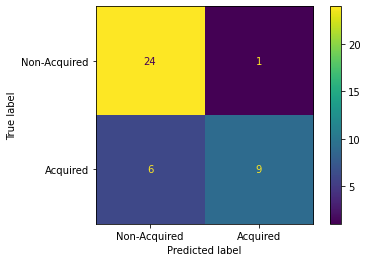

In [25]:
plot_confusion_matrix(rf, X_test, y_test, display_labels=['Non-Acquired','Acquired'])

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Precision : 0.9
Recall : 0.6
F1 : 0.7200000000000001
Accuracy : 0.825


In [27]:
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,7), dpi=1000)
tree.plot_tree(rf.estimators_[5],
               feature_names = features_df.columns, 
               class_names=["Non Acquired","Acquired"],
               max_depth=2,
               fontsize=7,
               filled = True);

# Support Vector Machine model

In [28]:
from sklearn import svm

In [29]:
features_df.isnull().sum()

Return on equity__max                    0
Return on equity__min                    0
Return on equity__variance               0
Return on equity__std                    0
Return on equity__sum                    0
                                        ..
Free Cash Flow Return__skew              0
Free Cash Flow Return__kurtosis          0
Free Cash Flow Return__cnt_above_mean    0
Free Cash Flow Return__cnt_below_mean    0
Acquisition Flag                         0
Length: 101, dtype: int64

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [32]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,...,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02,1.170000e+02
mean,-8.302950e-17,-1.755481e-17,6.998201e-18,-7.045646e-17,-2.087599e-17,-5.693451e-18,-4.744543e-18,-8.741820e-17,1.133946e-16,2.044898e-16,...,9.726313e-18,6.167906e-18,-3.083953e-18,-1.020077e-16,8.255505e-17,-1.233581e-17,-3.629575e-17,8.729959e-17,1.205114e-16,1.152924e-16
std,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,...,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00,1.004301e+00
min,-1.494158e+00,-1.023143e+01,-1.262535e-01,-4.250012e-01,-6.926421e+00,-6.683555e+00,-2.112692e+00,-1.153814e+00,-1.969953e+00,-1.800151e+00,...,-5.894271e-01,-8.427780e+00,-2.077609e-01,-6.368314e-01,-6.676376e+00,-6.608064e+00,-2.523138e+00,-1.048653e+00,-2.010730e+00,-2.079211e+00
25%,-5.408459e-01,3.381416e-02,-1.248094e-01,-3.077988e-01,-1.068080e-01,-1.278003e-01,-7.805447e-01,-7.685042e-01,-6.792398e-01,-8.268715e-01,...,-2.797416e-01,-1.550244e-02,-1.962793e-01,-3.558787e-01,-5.382879e-01,-4.934274e-01,-4.147375e-01,-7.206423e-01,-5.610927e-01,-5.185523e-01
50%,-2.084359e-01,2.010539e-01,-1.222905e-01,-2.308489e-01,1.142924e-01,1.024623e-01,1.645532e-01,-3.310085e-01,-1.260770e-01,1.464078e-01,...,-1.879829e-01,1.771451e-01,-1.806141e-01,-2.048228e-01,-5.210268e-02,-9.348706e-02,6.332414e-02,-3.948264e-01,-1.469107e-01,6.669483e-02
75%,1.330605e-01,2.602909e-01,-1.066122e-01,-1.800461e-02,4.010997e-01,3.903912e-01,7.333978e-01,3.933095e-01,6.114734e-01,7.303754e-01,...,-3.887508e-02,3.376848e-01,-1.463541e-01,-4.293493e-03,4.901808e-01,5.295014e-01,5.166077e-01,1.957500e-01,6.814533e-01,6.519420e-01
max,4.351664e+00,4.365655e-01,1.070690e+01,9.726025e+00,1.556823e+00,1.632156e+00,2.421175e+00,2.861885e+00,2.086574e+00,2.287622e+00,...,7.990008e+00,7.871958e-01,8.826461e+00,7.244118e+00,2.752812e+00,2.805807e+00,2.451010e+00,2.960332e+00,2.338181e+00,2.212601e+00


In [33]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred=svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.68


In [34]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0) 

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred_rbf=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_rbf)))

Model accuracy score with rbf kernel and C=100.0 : 0.7000


In [35]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 

# fit classifier to training set
linear_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=linear_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1.0 : 0.6000


In [36]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 

# fit classifier to training set
poly_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=poly_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.6250


In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rbf)
cm

array([[19,  6],
       [ 6,  9]])

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision : {precision_score(y_test, y_pred_rbf)}")
print(f"Recall : {recall_score(y_test, y_pred_rbf)}")
print(f"F1 : {f1_score(y_test, y_pred_rbf)}")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rbf)}")

Precision : 0.6
Recall : 0.6
F1 : 0.6
Accuracy : 0.7
